<a href="https://colab.research.google.com/github/sarahejaz/gonotes/blob/main/pitchTracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import math
import librosa

In [7]:
def divide_into_frames(y, frame_size, frame_stride, fs):
    frame_len = int(fs*frame_size) # number of samples in a single frame
    frame_step = int(fs*frame_stride) # number of overlapping samples
    total_frames = int(np.ceil(float(np.abs(len(y)-frame_len))/frame_step))
    print("Frame len %d, frame step %d, total frames %d"%(frame_len, frame_step, total_frames))
    padded_y = np.append(np.array(y), np.zeros(frame_len * total_frames - len(y)))
    framed_y = np.zeros((total_frames, frame_len))
    for i in range(total_frames):
        framed_y[i] = padded_y[i*frame_step : i*frame_step + frame_len] 
    print (framed_y.shape)
    return framed_y

def calculate_difference(signal) :
    half_len_signal = len(signal)//2
    tau = 0
    autocorr = np.zeros(half_len_signal)
    for tau in range(half_len_signal):
        for i in range(half_len_signal):
            diff = signal[i] - signal[i+tau]
            autocorr[tau] += diff**2
    
    return autocorr

def normalize_with_cumulative_mean(autocorr, halflen):
    new_autocorr = autocorr
    new_autocorr[0] = 1
    running_sum = 0.0
    for tau in range(1,halflen):
        running_sum += autocorr[tau]
        new_autocorr[tau] = autocorr[tau]/((1/tau)*running_sum)
    
    return new_autocorr

def absolute_threshold(new_autocorr, halflen, threshold):           
    temp = np.array(np.where(new_autocorr < threshold))
    if (temp.shape == (1,0)):
        tau = -1
    else : 
        tau = temp[:,0][0]
    return tau

def parabolic_interpolation(new_autocorr, tau, frame_len):
    if tau > 1 and tau < (frame_len//2-1):
        alpha = new_autocorr[tau-1]
        beta = new_autocorr[tau]
        gamma = new_autocorr[tau+1]
        improv = 0.5*(alpha - gamma)/(alpha - 2*beta + gamma)
    else :
        improv = 0
    
    new_tau = tau + improv
    return new_tau

def yin_pitchtracker(y, frame_size, frame_step, sr):
    framed_y = divide_into_frames(y, frame_size, frame_step, sr)
    pitches = []
    for i in range(len(framed_y)):
        autocorr = calculate_difference(framed_y[i])
        new_autocorr = normalize_with_cumulative_mean(autocorr, frame_len//2)
        tau = absolute_threshold(new_autocorr, frame_len//2, 0.16)
        new_tau = parabolic_interpolation(new_autocorr, tau, frame_len)
        if (new_tau == -1):
            pitch = 0
        else :
            pitch = sr/new_tau
        # print (pitch)
        pitches.append(pitch)
    return pitches



In [8]:
wf = "/content/audio.wav"
    # wf = 'OpenA.wav'
sr = 22050
y,sr = librosa.load(wf,sr=sr)
y = y[0:int(3.5*sr)]
print (sr)

frame_size = 0.03
frame_step = 0.01
frame_len = int(frame_size * sr)


pitches = yin_pitchtracker(y, frame_size, frame_step, sr)
print (pitches)

22050
Frame len 661, frame step 220, total frames 348
(348, 661)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


[0, 0, 0, 0, 0, 0, 0, 0, 123.06882682733024, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 177.7563381922316, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 626.0041419166589, 629.2396594589312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110.37763405309434, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 129.46192684644163, 121.19821487316545, 123.89025264165195, 122.49235245411916, 123.0943867449816, 0, 0, 0, 0, 121.50611478178305, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 123.38232606453406, 0, 0, 0, 0, 0, 0, 0, 124.67446305068134, 121.20750870890313, 110.8356342885019, 120.79399247966857, 121.00806243400719, 120.87269703686545, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 137.73260448230295, 136.23840350631727, 141.083016867107, 0, 139.69383075375555, 141.02041681963857, 142.29008410597552, 146.66086896692346, 149.7822503545768, 0, 0, 0, 166.68897879893262, 172.9119617413911, 176.37120947200472, 18

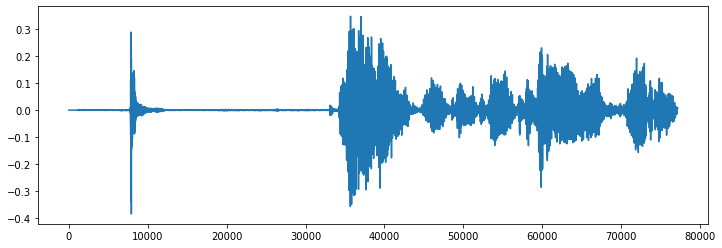

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,4))
plt.plot(y)